In [2]:
import pandas as pd
% matplotlib inline

# Steps
- create list of link IJs to pull from Soundcast results - bike_count_links.csv
- these links have a field "Oneway" that is 2 if they are bi-directional
- Soundcast will sum counts in both directions if oneway is equal to 2
- Perform similar split on the data itself so we can compare the counts vs actual

## To Do:
- Clean the data to get two-hour AM counts, single records per location or combine counts

## Process intersect data for export as Soundcast input
- this is the file that soundcast will use to pull out link results
- no need to split two-way links into seperate entries because this is done in the soundcast code


In [485]:
# Load data
count_intersect = pd.read_csv(r'R:\Bike\Counts\wsdot2015_counts_intersect_transRefEdges.csv')

In [486]:
# Pick some year and time of day for now
count_intersect = count_intersect[count_intersect['CountYear'] == 2015]
count_intersect = count_intersect[count_intersect['CountTime'] == 'AM']

In [487]:
# Drop the intersections since there are multiple counts per line, only concerned about geometry here
print len(count_intersect)
print len(count_intersect.drop_duplicates(['INode','JNode']))

count_intersect = count_intersect.drop_duplicates(['INode','JNode'])

448
442


In [482]:
len(twoway_links_df)

435

In [483]:
# # Replace I with J node for this new df
# twoway_links_df['tempINode'] = twoway_links_df['JNode']
# twoway_links_df['tempJNode'] = twoway_links_df['INode']
# twoway_links_df.drop(['INode','JNode'],axis=1)
# twoway_links_df['INode'] = twoway_links_df['tempINode']
# twoway_links_df['JNode'] = twoway_links_df['tempJNode']

# # Concatenate on the original df
# count_intersect = pd.concat([count_intersect,twoway_links_df])
# len(count_intersect)

In [427]:
# export this as an input for the bike model (list of I and J node to export from the network summary
count_intersect[['INode','JNode','LocationID','LocationDe','CityName','CountyName']].to_csv('bike_count_links.csv', index=False)

# bike_count_links.csv is an input for the bike model

# Count location totals
- now that we know the IJ of links intersecting the count location, need to summarize total counts at those locations

In [484]:
# twoway_links_df = count_intersect[count_intersect['Oneway'] == 2]

# # Replace I with J node for this new df
# twoway_links_df['tempINode'] = twoway_links_df['JNode']
# twoway_links_df['tempJNode'] = twoway_links_df['INode']
# twoway_links_df.drop(['INode','JNode'],axis=1)
# twoway_links_df['INode'] = twoway_links_df['tempINode']
# twoway_links_df['JNode'] = twoway_links_df['tempJNode']

# # Concatenate on the original df
# count_intersect = pd.concat([count_intersect,twoway_links_df])
# len(count_intersect)

In [454]:
# # all values should be the same
# count_totals = count_intersect.drop_duplicates('LocationDe')
# # count_totals = count_intersect[['Bike_Total','LocationDe']]
# count_totals = pd.DataFrame(count_totals.groupby('LocationDe').min())
# count_totals['LocationDe'] = count_totals.index

# # New field to combines city and lcoation description
# count_totals['Location'] = count_totals.CityName + ": " + count_totals.LocationDe

In [592]:
count_intersect[count_intersect['LocationID'] == 'Seattle2'][['CountYear','CountTime']]

,CountYear,CountTime
3735,2015,AM
3736,2015,AM
3737,2015,AM
3738,2015,AM
3739,2015,AM
3740,2015,AM
3741,2015,AM


## model counts
- load model results from bike_volumes
- requires run that used the above bike_count_links.csv

In [641]:
model = pd.read_csv(r'Q:\stefan\soundcast_runtime_test\soundcast\outputs\bike_volumes.csv')

In [662]:
# Group model results by the location description to get the sum for each location
model_totals = model.groupby('LocationID').sum()[['bvol7to8','bvol8to9']]
model_totals['LocationID'] = model_totals.index

# AM counts correspond to 7 to 9 AM for WSDOT data
model_totals['AM_bvol'] = model_totals['bvol7to8']+model_totals['bvol8to9']
model_totals['model'] = model_totals['AM_bvol']

# Since we are summing up bidirectional links (mostly), divide model totals by 2
model_totals['model'] = model_totals['model']/2

In [663]:
# Group count results to get the total
# note that we're taking the min, this value should be the same for each LocationID,
# since these were intersected with a single count value
count_totals = pd.DataFrame(count_intersect.groupby('LocationID').min()['Bike_Total'])
count_totals['LocationID'] = count_totals.index
count_totals['observed'] = count_totals['Bike_Total']

In [664]:
# Join with model and count
df = pd.merge(left=model_totals[['LocationID','model']], right=count_totals[['LocationID','observed']], 
              on='LocationID',how='left')


df = pd.merge(df, count_intersect[['LocationID','LocationDe','CityName','CountyName']].drop_duplicates('LocationID'), on='LocationID',how='left')


In [665]:
# Look up the location description from the intersect

In [666]:
df.index = df['LocationDe']

In [667]:
# Counts don't match up with observed link locations
list_of_missing = df[df['model'].isnull()]['LocationDe'].values

In [668]:
# Available
available_counts = df[-df['model'].isnull()]

In [669]:
# Ignore locations that have 0 counts or modeled flows - could be errors
available_counts = available_counts[(available_counts['model'] > 0) & (available_counts['observed'] > 0)]

# Point Location Results

### Seattle

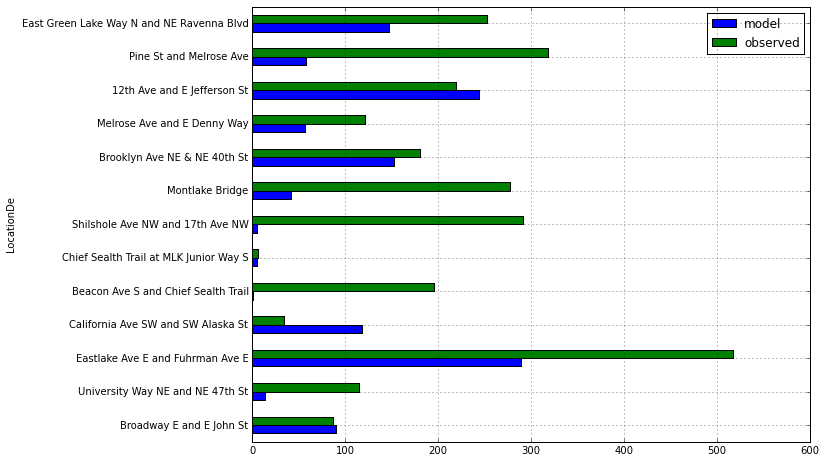

In [670]:
cityname = 'Seattle'
df = available_counts[available_counts['CityName'] == cityname]
df[['model','observed']].plot(kind='barh',figsize=(10,len(df)*.6))

### Bellevue

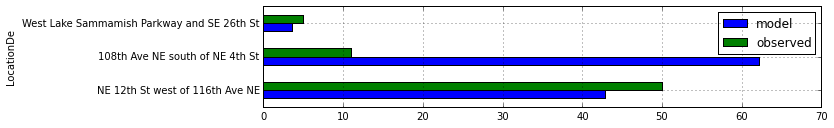

In [671]:
cityname = 'Bellevue'
df = available_counts[available_counts['CityName'] == cityname]
df[['model','observed']].plot(kind='barh',figsize=(10,len(df)*.6))

### Lakewood

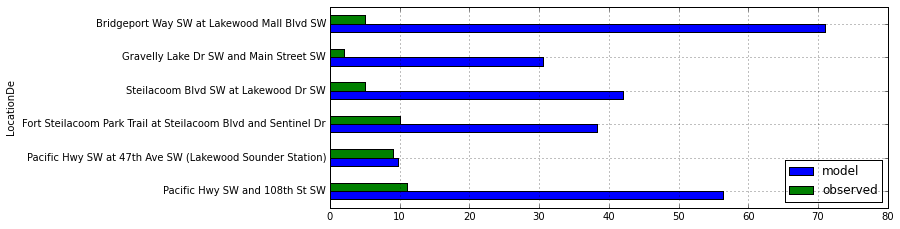

In [672]:
cityname = 'Lakewood'
df = available_counts[available_counts['CityName'] == cityname]
df[['model','observed']].plot(kind='barh',figsize=(10,len(df)*.6))

### Everett

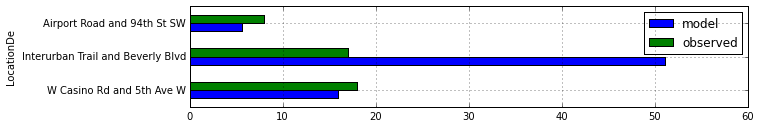

In [673]:
cityname = 'Everett'
df = available_counts[available_counts['CityName'] == cityname]
df[['model','observed']].plot(kind='barh',figsize=(10,len(df)*.6))

## By County

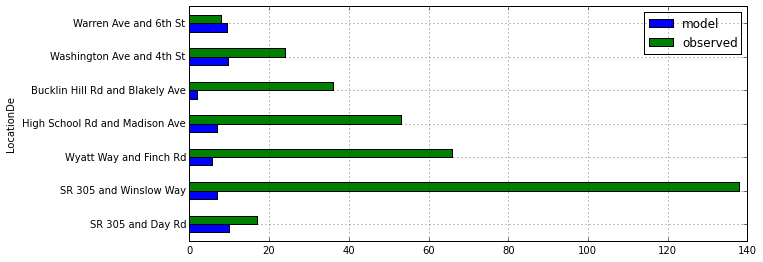

In [674]:
countyname = 'Kitsap County'
df = available_counts[available_counts['CountyName'] == countyname]
df[['model','observed']].plot(kind='barh',figsize=(10,len(df)*.6))

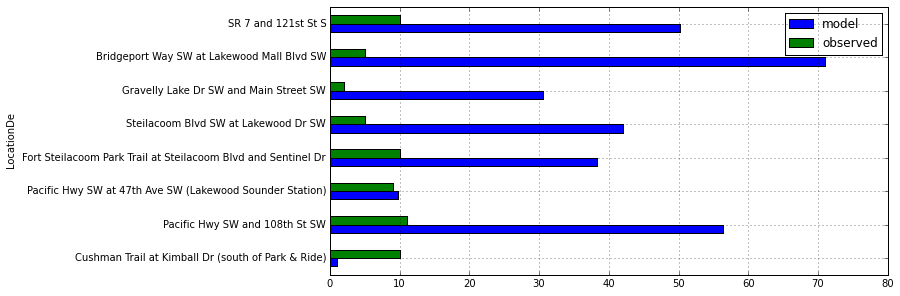

In [675]:
countyname = 'Pierce County'
df = available_counts[available_counts['CountyName'] == countyname]
df[['model','observed']].plot(kind='barh',figsize=(10,len(df)*.6))

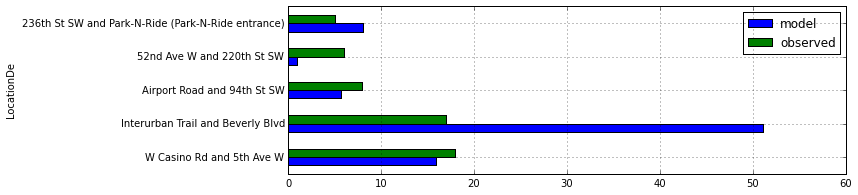

In [676]:
countyname = 'Snohomish County'
df = available_counts[available_counts['CountyName'] == countyname]
df[['model','observed']].plot(kind='barh',figsize=(10,len(df)*.6))

# Scatterplot

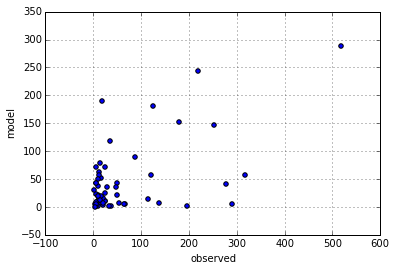

In [677]:
available_counts.plot(kind='scatter',x='observed', y='model')

In [607]:
available_counts.sort('model',ascending=False)

,LocationID,model,observed,LocationDe,CityName,CountyName
LocationDe,,,,,,
Eastlake Ave E and Fuhrman Ave E,Seattle2,577.732296,517,Eastlake Ave E and Fuhrman Ave E,Seattle,King County
12th Ave and E Jefferson St,Seattle48,488.698614,219,12th Ave and E Jefferson St,Seattle,King County
NE 116th St west of 124th Ave NE,Kirkland6,378.424800,18,NE 116th St west of 124th Ave NE,Kirkland,King County
Burke Gilman Trail west of 61st Ave NE,Kenmore5,361.398726,125,Burke Gilman Trail west of 61st Ave NE,Kenmore,King County
Brooklyn Ave NE & NE 40th St,Seattle42,304.718940,180,Brooklyn Ave NE & NE 40th St,Seattle,King County
East Green Lake Way N and NE Ravenna Blvd,Seattle8,294.425144,253,East Green Lake Way N and NE Ravenna Blvd,Seattle,King County
California Ave SW and SW Alaska St,Seattle21,235.212888,34,California Ave SW and SW Alaska St,Seattle,King County
Broadway E and E John St,Seattle14,180.321487,87,Broadway E and E John St,Seattle,King County
Simonds Rd NE and 100th Ave NE,Kirkland8,156.010281,15,Simonds Rd NE and 100th Ave NE,Kirkland,King County


# Map count locations

In [608]:
import folium
import vincent
import json
import matplotlib
import matplotlib.pyplot as plt
vincent.core.initialize_notebook()

In [621]:
df = available_counts
df = pd.merge(df,count_intersect,on='LocationID',how='left').drop_duplicates(['LocationID'])

In [622]:

df['% diff'] = (df['model']-df['observed'])/df['observed']
df['% abs diff'] = df['% diff'].abs()

In [623]:
# Show locations, with red indicating the largest differences
map_osm = folium.Map(location=[47.5836, -122.3750], zoom_start=10, tiles='Stamen Toner')

df_dict = df.to_dict(orient='records')

for i in xrange(len(df_dict)):
    color = 'green'
    lat = df_dict[i]['Latitude']
    lon = df_dict[i]['Longitude']
    diff = df_dict[i]['% abs diff']
    name = df_dict[i]['LocationID']
    
    # Set color based on % difference
    color_map = plt.get_cmap('Reds')

    marker = folium.RegularPolygonMarker(location=[lat, lon], popup=name+": "+str(diff),
                   fill_color=matplotlib.colors.rgb2hex(color_map(diff)), number_of_sides=8, radius=10).add_to(map_osm)
    
    map_osm.add_children(marker);

map_osm.save('osm.html')

In [624]:
map_osm

In [298]:
df['% abs diff']

Location
Bainbridge Island: High School Rd and Madison Ave               0.962117
Bainbridge Island: SR 305 and Winslow Way                       0.963697
Bainbridge Island: Wyatt Way and Finch Rd                       0.860369
Bellevue: 108th Ave NE south of NE 4th St                       0.172727
Bellevue: NE 12th St west of 116th Ave NE                       0.676000
Bothell: SR 527 and 214th St SE                                 0.299951
Bremerton: Washington Ave and 4th St                            0.987500
Gig Harbor: Cushman Trail at Kimball Dr (south of Park & Ride)    0.890000
Kent: Interurban Trail at W James St                            0.779592
Kent: SE 240th St and 116th Ave SE                              0.200000
Kirkland: NE 116th St west of 124th Ave NE                      0.525263
Kirkland: Simonds Rd NE and 100th Ave NE                        0.933333
Lake Forest Park: Brookside Blvd NE and NE 178 St               0.875000
Lakewood: Bridgeport Way SW at Lakewood 

# Load Emme maps?